In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torchtext
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import os
import string
import math
import nltk

from model import EncoderCNN, DecoderRNN
from classes import COCODataset
from helper import *

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Hyperparameters

BATCH_SIZE = 32
IMG_SIZE = 224

EMBED_SIZE = 300
HIDDEN_SIZE = 100

MIN_VOCAB_FREQS = 1
MAX_VOCAB_SIZE = 20000

In [4]:
MAKE_ANNOTATION_TEXT_FILE = 0
TRAIN_DATA = 0

In [5]:
DATA_DIR = {
    "train": "data/train2017",
    "val": "data/val2017",
    "test": "data/test2017",
    "annotation": {
        "train": "data/annotations/captions_train2017.json",
        "val": "data/annotations/captions_val2017.json"
    }
}

In [6]:
traindict = process_data(DATA_DIR["annotation"]["train"])
valdict = process_data(DATA_DIR["annotation"]["val"])

TRAINING_SAMPLES = len(traindict)
print(f"Number of training samples: {TRAINING_SAMPLES} images")

Number of training samples: 118287 images


In [7]:
if MAKE_ANNOTATION_TEXT_FILE:
    import csv
    with open("data/train_annotation_text.csv", "w", newline="") as fi:
        writer = csv.writer(fi)
        for i in tqdm(range(len(traindict))):
            anno = list(traindict.values())[i]["captions"]
            for line in anno:
                writer.writerow([line])

In [8]:
data_transform = {
    "train": transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomCrop((IMG_SIZE,IMG_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
    
    "val": transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
}

In [9]:
trainset = COCODataset(DATA_DIR["train"],traindict,data_transform["train"])
valset = COCODataset(DATA_DIR["val"],valdict,data_transform["val"])

Vocabulary successfully loaded from vocab.pkl file!



Vocabulary successfully loaded from vocab.pkl file!


In [10]:
VOCAB_SIZE = len(trainset.vocab)
print(f"Number of unique words from the dataset: {VOCAB_SIZE} words")

Number of unique words from the dataset: 11559 words


closeup of a green bowl holding pieces of broccoli .


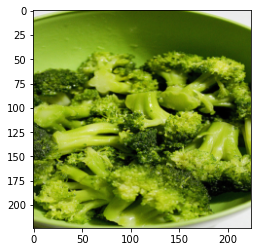

a man standing outside on the grass at night making body motions .


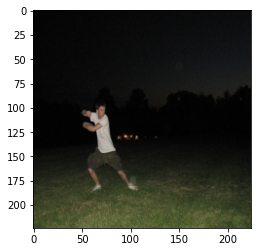

parks benches sit on the leaf covered ground overlooking the water .


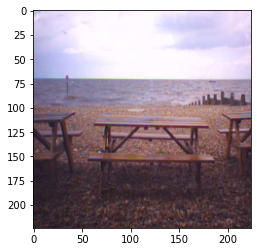

people carrying colorful umbrellas walking down sidewalk in the rain .


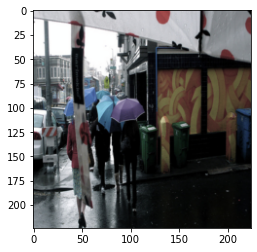

a large parachute is flying in the sky


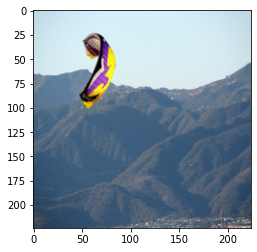

In [11]:
%matplotlib inline
def visualize_training(NUM_PIC = 5 ):
    for i in range(NUM_PIC):
        a = np.random.randint(TRAINING_SAMPLES-NUM_PIC)
        item = trainset[a]
        img_show, caps = trainset.imshow(item)
        plt.imshow(img_show)
        print(caps)
        plt.show()
visualize_training()

In [12]:
indices = trainset.get_train_indices(BATCH_SIZE)
initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
trainloader = data.DataLoader(trainset,
                              num_workers= 0, 
                             batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                    batch_size=BATCH_SIZE,
                                                                    drop_last=False))
valloader = data.DataLoader(valset, batch_size=1, num_workers= 0)

In [13]:
from torchsummary import summary

encoder = EncoderCNN(EMBED_SIZE).to(device)
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE).to(device)

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn1.parameters())
optimizer = torch.optim.Adam(params=params, lr = 1e-3)

criterion = nn.CrossEntropyLoss()

total_step = math.ceil(len(trainloader.dataset.caption_lengths) / BATCH_SIZE)
#print(encoder)
print(decoder)

DecoderRNN(
  (word_embeddings): Embedding(11559, 300)
  (linear): Linear(in_features=100, out_features=11559, bias=True)
  (lstm): LSTM(300, 100, batch_first=True)
)


In [14]:
def get_prediction(encoder,decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        a = np.random.randint(3000)
        batch = valset[a]

        imgs = batch["img"].unsqueeze(0).to(device)
        caps = batch["captions"]
        
        img_show,_ = valset.imshow(batch,train=False)
        features = encoder(imgs).unsqueeze(1)
        output = decoder.sample(features)
        sentence = valloader.dataset.clean_sentence(output)
        plt.imshow(img_show)
        plt.axis("off")
        plt.show()
        print("Generated Caption: " + sentence)
        print("Ground Truth: " + caps)
    encoder.train()
    decoder.train()

In [15]:
def train(encoder, decoder, optimizer, criterion, trainloader):
    
    EPOCHS = 5
    running_loss = 0
    lowest_perplexity = 8.4605
    for epoch in range(EPOCHS):
        for idx in tqdm(range(0,total_step)):
            encoder.train()
            decoder.train()
            indices = trainloader.dataset.get_train_indices(BATCH_SIZE)
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            trainloader.batch_sampler.sampler = new_sampler
            batchdict = next(iter(trainloader))
            
            
            decoder.zero_grad()
            encoder.zero_grad()
            
            imgs = batchdict["img"].to(device)
            caps = batchdict["captions_idx"]
        
            captions_target = caps[:, :].to(device)
            captions_train = caps.to(device)
           
            features  = encoder(imgs)
            output = decoder(features,captions_train)
           
            loss = criterion(output.view(-1, VOCAB_SIZE), captions_target.contiguous().view(-1))  
            perplexity = np.exp(loss.item())
            loss.backward()
            optimizer.step()
            
            if idx%300 == 0:
                print(f"Epoch: [{epoch+1}|{EPOCHS}] | Batch: [{idx+1}|{total_step}]")
                print(f"\tLoss: {loss.data:.4f} | Perplexity: {perplexity:.4f}")
                get_prediction(encoder,decoder)
                if perplexity < lowest_perplexity:
                    lowest_perplexity = perplexity
                    torch.save(encoder.state_dict(), "model/encoder-resnet2.pt")
                    torch.save(decoder.state_dict(), "model/decoder-resnet2.pt")
                    print("Model saved!")

    return encoder, decoder

Epoch: [1|3] | Batch: [1|3697]
	Loss: 9.3523 | Perplexity: 11525.2646


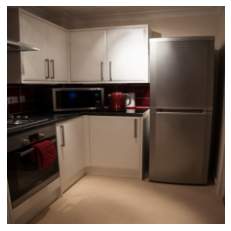

Generated Caption: Tots stepping pickled disconnected pared holidng hookah switch bun witches t-ball si root mode participate hits motoring underpass granny dull
Ground Truth: a small kitchen is shown it has many appliances .
Epoch: [1|3] | Batch: [301|3697]
	Loss: 4.8556 | Perplexity: 128.4599


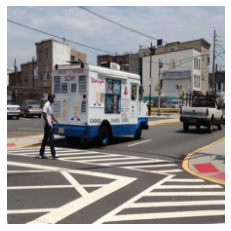

Generated Caption: <start> a man is a man on a man . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: the man is walking behind the concession bus .
Model saved!
Epoch: [1|3] | Batch: [601|3697]
	Loss: 3.7069 | Perplexity: 40.7274


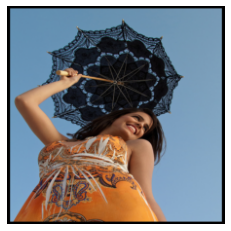

Generated Caption: <start> a man is sitting on a table . <end> <end> . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a woman holds an umbrella in the air
Model saved!
Epoch: [1|3] | Batch: [901|3697]
	Loss: 3.6922 | Perplexity: 40.1338


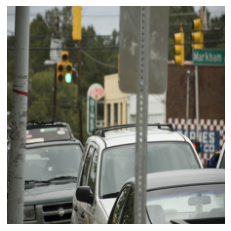

Generated Caption: <start> a man is sitting on a table with a table . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a busy traffic area on a street during the day .
Model saved!
Epoch: [1|3] | Batch: [1201|3697]
	Loss: 3.5731 | Perplexity: 35.6263


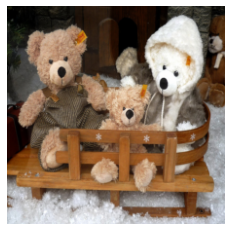

Generated Caption: <start> a man in a small bathroom with a toilet and a table . <end> <end> . <end> <end> .
Ground Truth: a set of plush toy teddy bears sitting in a sled .
Model saved!
Epoch: [1|3] | Batch: [1501|3697]
	Loss: 2.9430 | Perplexity: 18.9734


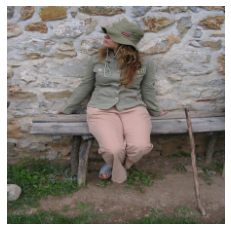

Generated Caption: <start> a man is riding a skateboard on a skateboard . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a woman sitting on a wooden bench next to a rock wall .
Model saved!
Epoch: [1|3] | Batch: [1801|3697]
	Loss: 3.0496 | Perplexity: 21.1078


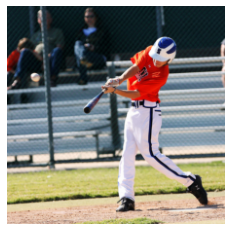

Generated Caption: <start> a man is standing on a tennis court . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: a baseball player hitting the ball during a baseball game .
Epoch: [1|3] | Batch: [2101|3697]
	Loss: 2.7041 | Perplexity: 14.9414


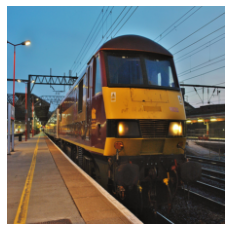

Generated Caption: <start> a train is parked on the tracks . <end> <end> . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a passanger train stopped on the railroad tracks at a station .
Model saved!
Epoch: [1|3] | Batch: [2401|3697]
	Loss: 3.0660 | Perplexity: 21.4558


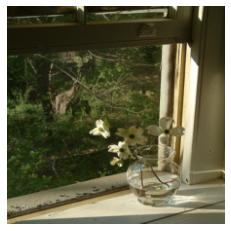

Generated Caption: <start> a large white cat sitting on a bed . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: a vase with white flowers sitting next to an open window .
Epoch: [1|3] | Batch: [2701|3697]
	Loss: 2.7252 | Perplexity: 15.2601


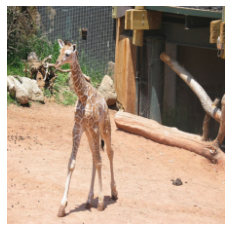

Generated Caption: <start> a giraffe standing in a field of a field . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a small giraffe walking on a dirt ground
Epoch: [1|3] | Batch: [3001|3697]
	Loss: 2.6788 | Perplexity: 14.5672


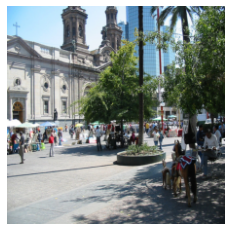

Generated Caption: <start> a man is standing on a motorcycle . <end> <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: a dog is next to a tree and a bunch of people are walking up to colored umbrellas and some have rested under a tree .
Model saved!
Epoch: [1|3] | Batch: [3301|3697]
	Loss: 2.9332 | Perplexity: 18.7885


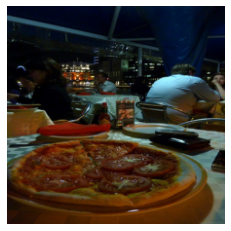

Generated Caption: <start> a man is sitting on a table with a laptop and a laptop . <end> <end> . <end> <end>
Ground Truth: a pizza with tomatoes on it sitting on a table in a restaurant .
Epoch: [1|3] | Batch: [3601|3697]
	Loss: 2.3685 | Perplexity: 10.6811


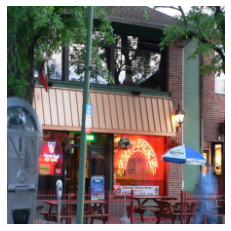

Generated Caption: <start> a street sign with a clock on the street . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a city street scene of a restaurant with tables outside .
Model saved!



Epoch: [2|3] | Batch: [1|3697]
	Loss: 2.6313 | Perplexity: 13.8924


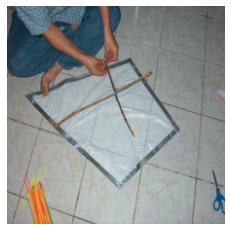

Generated Caption: <start> a man in a suit is holding a tennis racket . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a person crafting a kite around two sticks .
Epoch: [2|3] | Batch: [301|3697]
	Loss: 2.9982 | Perplexity: 20.0491


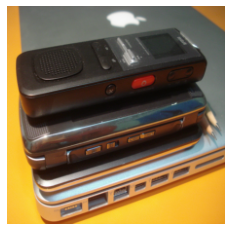

Generated Caption: <start> a white and white photo of a man in a white shirt and a window . <end> <end> .
Ground Truth: a laptop and three cellphones on a yellow table
Epoch: [2|3] | Batch: [601|3697]
	Loss: 2.5897 | Perplexity: 13.3263


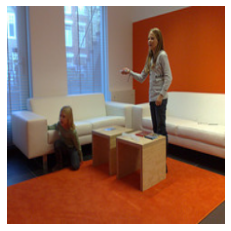

Generated Caption: <start> a man in a kitchen with a laptop and a bed . <end> <end> . <end> <end> . <end>
Ground Truth: two girls play wii in a room with ourange rugs and white sofas .
Epoch: [2|3] | Batch: [901|3697]
	Loss: 2.7275 | Perplexity: 15.2942


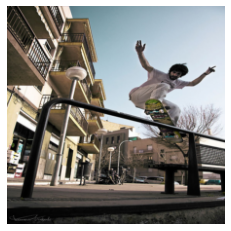

Generated Caption: <start> a man on a skateboard on a skateboard . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: a man performs a trick on a skateboard over a rail .
Epoch: [2|3] | Batch: [1201|3697]
	Loss: 2.7919 | Perplexity: 16.3128


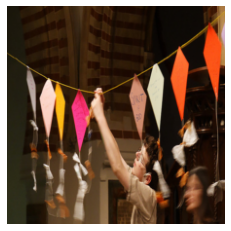

Generated Caption: <start> a group of people are standing in the water . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a boy hangs up paper kites on a string .
Epoch: [2|3] | Batch: [1501|3697]
	Loss: 3.1971 | Perplexity: 24.4610


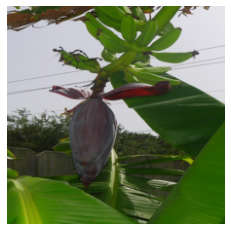

Generated Caption: <start> a close up of a bird perched on a branch . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a bunch of bananas are hanging from the banana tree
Epoch: [2|3] | Batch: [1801|3697]
	Loss: 2.4214 | Perplexity: 11.2619


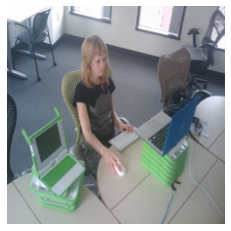

Generated Caption: <start> a man is sitting on a couch with a laptop . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a woman works at a computer workstation in an office .
Epoch: [2|3] | Batch: [2101|3697]
	Loss: 2.5412 | Perplexity: 12.6944


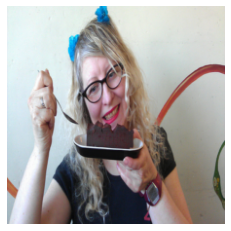

Generated Caption: <start> a woman is holding a wii controller . <end> <end> . <end> <end> . <end> <end> . <end> <end>
Ground Truth: an image of a woman about to eat a slice of cake
Epoch: [2|3] | Batch: [2401|3697]
	Loss: 2.4901 | Perplexity: 12.0630


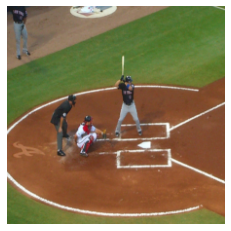

Generated Caption: <start> a baseball player is swinging a bat at a baseball game . <end> <end> . <end> <end> . <end>
Ground Truth: a batter up to bat at a baseball game .
Epoch: [2|3] | Batch: [2701|3697]
	Loss: 2.2683 | Perplexity: 9.6627


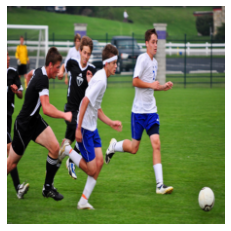

Generated Caption: <start> a group of people are playing soccer on a field . <end> <end> . <end> <end> . <end> <end>
Ground Truth: group of soccer players on field kicking ball .
Model saved!
Epoch: [2|3] | Batch: [3001|3697]
	Loss: 2.4071 | Perplexity: 11.1022


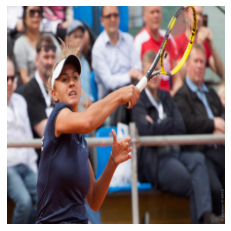

Generated Caption: <start> a man is playing tennis on a tennis court . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a woman swinging her tennis racket while playing tennis
Epoch: [2|3] | Batch: [3301|3697]
	Loss: 2.4769 | Perplexity: 11.9041


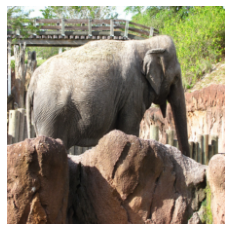

Generated Caption: <start> a couple of elephants standing in a field . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: an elephant in captivity with trees in the background
Epoch: [2|3] | Batch: [3601|3697]
	Loss: 2.4325 | Perplexity: 11.3875


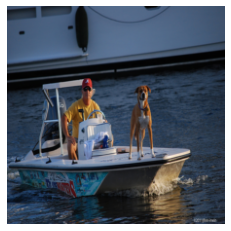

Generated Caption: <start> a man is surfing on a wave in the ocean . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a man in a hat and glasses is sitting on a boat with a dog .



Epoch: [3|3] | Batch: [1|3697]
	Loss: 2.5387 | Perplexity: 12.6638


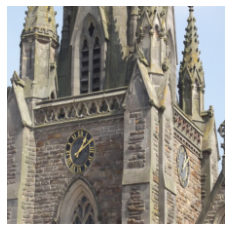

Generated Caption: <start> a large clock tower in a city area . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: a large building is shown with clocks on the side .
Epoch: [3|3] | Batch: [301|3697]
	Loss: 2.4510 | Perplexity: 11.5999


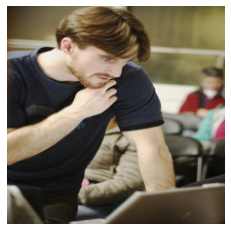

Generated Caption: <start> a man is sitting in a kitchen with a bed . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a man looking down at an open laptop .
Epoch: [3|3] | Batch: [601|3697]
	Loss: 4.1924 | Perplexity: 66.1801


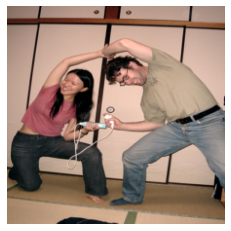

Generated Caption: <start> a man and a woman in a suit and tie . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a couple fighting each other over a wii remote control
Epoch: [3|3] | Batch: [901|3697]
	Loss: 2.8353 | Perplexity: 17.0349


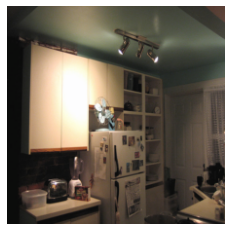

Generated Caption: <start> a living room with a couch and a couch <end> . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a kitchen illuminated by a track lighting unit .
Epoch: [3|3] | Batch: [1201|3697]
	Loss: 2.1764 | Perplexity: 8.8143


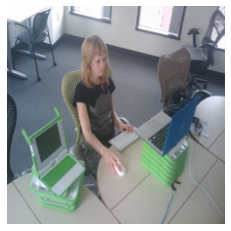

Generated Caption: <start> a man is standing in front of a computer screen . <end> <end> . <end> <end> . <end> <end>
Ground Truth: a woman works at a computer workstation in an office .
Model saved!
Epoch: [3|3] | Batch: [1501|3697]
	Loss: 2.3900 | Perplexity: 10.9139


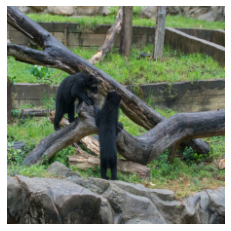

Generated Caption: <start> a bear that is standing in the grass . <end> <end> . <end> <end> . <end> <end> . <end>
Ground Truth: two animals playing outside on a tree branch .
Epoch: [3|3] | Batch: [1801|3697]
	Loss: 2.4730 | Perplexity: 11.8578


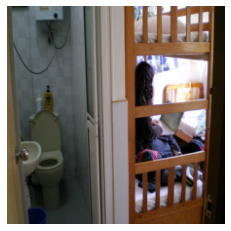

Generated Caption: <start> a bathroom with a toilet and a sink <end> . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: three people live in one room who share a bathroom .
Epoch: [3|3] | Batch: [2101|3697]
	Loss: 2.4203 | Perplexity: 11.2497


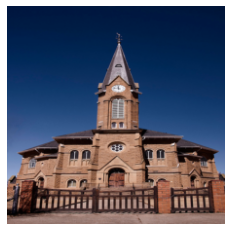

Generated Caption: <start> a clock tower with a clock on the side of it . <end> <end> . <end> <end> . <end>
Ground Truth: a tall tower with a clock on top
Epoch: [3|3] | Batch: [2401|3697]
	Loss: 2.5255 | Perplexity: 12.4974


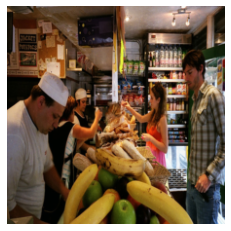

Generated Caption: <start> a man is standing in front of a store . <end> <end> . <end> from a large elephant .
Ground Truth: two customers and three employees interact in the deli .
Epoch: [3|3] | Batch: [2701|3697]
	Loss: 2.2077 | Perplexity: 9.0945


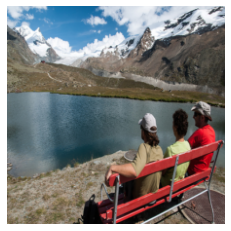

Generated Caption: <start> a man is riding a horse in a field . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: three persons seated on a bench near a pool of water
Epoch: [3|3] | Batch: [3001|3697]
	Loss: 2.2435 | Perplexity: 9.4267


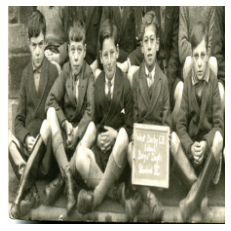

Generated Caption: <start> a group of people sitting on a bench <end> . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: black and white photograph of young schoolboys .
Epoch: [3|3] | Batch: [3301|3697]
	Loss: 2.3478 | Perplexity: 10.4625


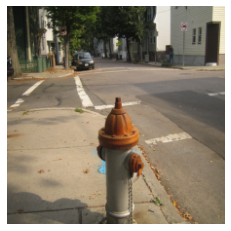

Generated Caption: <start> a fire hydrant on a sidewalk near a building . <end> <end> . <end> <end> . <end> <end> .
Ground Truth: a red and grey fire hydrant on a street corner .
Epoch: [3|3] | Batch: [3601|3697]
	Loss: 2.1354 | Perplexity: 8.4605


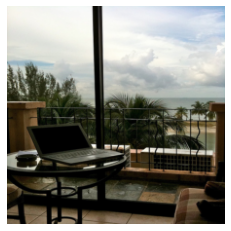

Generated Caption: <start> a desk with a computer and a laptop on a desk . <end> <end> . <end> <end> . <end>
Ground Truth: a laptop on a table on balcony , blue sky .
Model saved!



In [16]:
if TRAIN_DATA:
    encoder, decoder = train(encoder, decoder, optimizer, criterion, trainloader)

In [16]:
if not TRAIN_DATA:
    encoder.load_state_dict(torch.load("model/encoder-resnet.pt"))
    decoder.load_state_dict(torch.load("model/decoder-resnet.pt"))

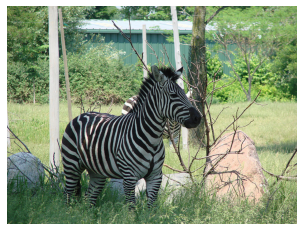

Generated Caption: A zebra standing in a field with a frisbee in its mouth .


In [18]:
def predict_single(encoder, decoder):
    a = np.random.randint(5000)
    path = os.listdir(DATA_DIR["val"])[a]
    img = Image.open(os.path.join(DATA_DIR["val"], path))
    plt.axis("off")
    plt.imshow(img)
    plt.show()
    img = data_transform["val"](img)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        
        features = encoder(img).unsqueeze(1)
        output = decoder.sample(features,max_len = 20)    
        sentence = trainloader.dataset.clean_sentence(output)
        print("Generated Caption: " + sentence)
        
        
predict_single(encoder,decoder)